In [1]:
%matplotlib inline
import os
import operator
import numpy as np
import pandas as pd
from football_loader import metrics


def load_league_csv(league, start_year=2005):
    df = None
    files = os.listdir(f'fulldata/{league}')
    files.sort()
    for file in files:
        year = int(file.strip('.csv'))
        if year < start_year:
            continue
        df_year = pd.read_csv(f'fulldata/{league}/' + file,
                              engine='python',
                              # skiprows=1,
                              # index_col=None,
                              # names=['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
                              )
        df_year.reset_index(drop=True, inplace=True)
        df_year['Year'] = year
        df_year['Match'] = df_year.index + 1

        if df is None:
            df = df_year
        else:
            df = df.append(df_year, ignore_index=True, sort=False)

    # print(len(df))
    # print(df.shape)

    # remove unused columns
    # df_league = None
    df.reset_index(inplace=True)
    # df = df[['Year', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    #          "B365H", "B365D", "B365A"]]
    return df


def make_features(df, teams, train_year, validate_year, test_year):
    # df_league = None
    ret = {}

    # if teams is None:
    #     teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
    #     teams.sort()
    for team in teams:

        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        all = pd.DataFrame(
            data={
                'Year': df_team['Year'],
                'Date': df_team['Date'],
                'Team': team,
                'HomeMatch': df_team['HomeTeam'] == team
            }
        )
        all['Opponent'] = np.where(all['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
        # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
        # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
        # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
        # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
        # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
        # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
        all['FTR'] = df_team['FTR']
        all['Won'] = np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
        all['Draw'] = df_team['FTR'] == 'D'
        all['Lost'] = np.where(all['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H')
        all['Result'] = np.where(all['Won'], 'Win', (np.where(all['Lost'], 'Lose', 'Draw')))
        # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
        all['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Say'] = np.where(all['HomeMatch'],
                                  # home match
                                  np.where(all['B365Max'] == df_team['B365H'], -1,
                                           np.where(all['B365Max'] == df_team['B365A'], 1,
                                                    0)),
                                  # away match
                                  np.where(all['B365Max'] == df_team['B365H'], 1,
                                           np.where(all['B365Max'] == df_team['B365A'], -1,
                                                    0))
                                  )
        all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Max'] - all['B365Min'],
                                   all['B365Min'] - all['B365Max'])
        all['Corners'] = np.where(all['HomeMatch'], df_team['HC'], df_team['AC'])
        all['Shots'] = np.where(all['HomeMatch'], df_team['HS'], df_team['AS'])
        all['ShotsOnTarget'] = np.where(all['HomeMatch'], df_team['HST'], df_team['AST'])
        all['Points'] = np.where(all['Won'], 3,
                                 np.where(all['Draw'], 1, 0)
                                  )
        all['AdjustedPoints'] = np.where(all['HomeMatch'],
                                  # home match
                                         np.where(all['Won'], 1,
                                                  np.where(all['Draw'], 0, -1)
                                                  )
                                         ,
                                  # away match
                                         np.where(all['Won'], 1.5,
                                                  np.where(all['Draw'], 0.5, 0)
                                                  )
                                  )

        # find number of times won against this opponent in last 5 meetings
        for key, groupByOpponent in all.groupby('Opponent'):
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByOpponent.index

            # make match day an index because rolling need an index date
            xx = groupByOpponent.set_index('Date')
            xx['idx'] = idx
            # shift to exclude self
            xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['Last5AgainstThisOpponentLost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['LastThisOpponentLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            all.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
            all.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
            # X.loc[xx.index, 'Last5AgainstThisOpponentLost'] = xx['Last5AgainstThisOpponentLost']
            all.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
            all.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
            all.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
            all.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']
            # X.loc[xx.index, 'LastThisOpponentLost'] = xx['LastThisOpponentLost']

        # stats by year/season
        for year, groupByYear in all.groupby('Year'):
            # print(year)
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByYear.index

            # make match day an index because rolling need an index date
            xx = groupByYear.set_index('Date')
            xx['idx'] = idx

            # shift to exclude self
            xx['CornersSoFar'] = np.nancumsum(xx['Corners'].shift())
            xx['ShotsSoFar'] = np.nancumsum(xx['Shots'].shift())
            xx['ShotsOnTargetSoFar'] = np.nancumsum(xx['ShotsOnTarget'].shift())

            xx['HomeWonNum'] = np.where(xx['HomeMatch'] & xx['Won'], 1, 0)
            xx['HomeWonSoFar'] = np.nancumsum(xx['HomeWonNum'].shift())
            xx['AwayWonNum'] = np.where((xx['HomeMatch'] == False) & xx['Won'], 1, 0)
            xx['AwayWonSoFar'] = np.nancumsum(xx['AwayWonNum'].shift())

            xx['PointsSoFar'] = np.nancumsum(xx['Points'].shift())
            xx['AdjustedPointsSoFar'] = np.nancumsum(xx['AdjustedPoints'].shift())

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
#             all.loc[xx.index, 'CornersSoFar'] = xx['CornersSoFar']
#             all.loc[xx.index, 'ShotsSoFar'] = xx['ShotsSoFar']
#             all.loc[xx.index, 'ShotsOnTargetSoFar'] = xx['ShotsOnTargetSoFar']
#             all.loc[xx.index, 'HomeWonSoFar'] = xx['HomeWonSoFar']
#             all.loc[xx.index, 'AwayWonSoFar'] = xx['AwayWonSoFar']
            all.loc[xx.index, 'PointsSoFar'] = xx['PointsSoFar']
            all.loc[xx.index, 'AdjustedPointsSoFar'] = xx['AdjustedPointsSoFar']

        # find recent forms
        idx = all.index
        xx = all.set_index('Date')
        xx['idx'] = idx
        xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        # xx['Last5Lost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')
        # assign back to the big dataframe
        all.loc[xx.index, 'Last5Won'] = xx['Last5Won']
        all.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
        all.loc[xx.index, 'Last3Won'] = xx['Last3Won']
        all.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
        all.loc[xx.index, 'LastWon'] = xx['LastWon']
        all.loc[xx.index, 'LastDraw'] = xx['LastDraw']
        # X.loc[xx.index, 'Last5Lost'] = xx['Last5Lost']

        # replace nan with 0
        # TODO: better way to handle nan
        all.loc[np.isnan(all['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['Last5AgainstThisOpponentLost']), 'Last5AgainstThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['LastThisOpponentLost']), 'LastThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last5Won']), 'Last5Won'] = 0
        all.loc[np.isnan(all['Last5Draw']), 'Last5Draw'] = 0
        # X.loc[np.isnan(X['Last5Lost']), 'Last5Lost'] = 0
        all.loc[np.isnan(all['Last3Won']), 'Last3Won'] = 0
        all.loc[np.isnan(all['Last3Draw']), 'Last3Draw'] = 0
        all.loc[np.isnan(all['LastWon']), 'LastWon'] = 0
        all.loc[np.isnan(all['LastDraw']), 'LastDraw'] = 0
        all.loc[np.isnan(all['B365Diff']), 'B365Diff'] = 0

        # restrict training data (too old data may not be irrelevance)
        X = all
        Y = X[['Result']]
        # del X['Result']
        # X = all.loc[(all['Year'] >= train_year) & (all['Year'] < predict_year)]
        # Y = all[['Result']]

        # split data into train - test sets
        # x_train = X[(X['Year'] < predict_year)]
        # y_train = Y[(X['Year'] < predict_year)]
        # x_test = X[(X['Year'] >= predict_year)]
        # y_test = Y[(X['Year'] >= predict_year)]
        # X['Predict'] = ''
        close_leaks(X)
        ret[team] = [X, Y]
    return ret


# call this after you've split data
def close_leaks(X):
    # remove duplicate features
    del X['LastWon']
    del X['LastDraw']

    # prevent future leaks
    # result = pd.DataFrame(X['Result'])
    del X['Result']
    del X['Lost']
    del X['Draw']
    del X['Won']
    del X['FTR']
    del X['Date']
    del X['Opponent']
    del X['Team']
    del X['B365Max']
    del X['B365Min']
    del X['Corners']
    del X['Shots']
    del X['ShotsOnTarget']
    del X['Points']
    del X['AdjustedPoints']


In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [3]:
league = 'french'
validate_year = 2016
test_year = 2017
train_year = 2005
df = load_league_csv(league)

In [4]:
teams = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
teams = teams.unique()
teams.sort()
print(teams)
print(len(teams))

['Amiens' 'Angers' 'Bastia' 'Bordeaux' 'Caen' 'Dijon' 'Guingamp' 'Lille'
 'Lorient' 'Lyon' 'Marseille' 'Metz' 'Monaco' 'Montpellier' 'Nancy'
 'Nantes' 'Nice' 'Paris SG' 'Rennes' 'St Etienne' 'Strasbourg' 'Toulouse'
 'Troyes']
23


In [5]:
teams = make_features(df, teams, train_year, validate_year, test_year)
classes = ['Draw', 'Lose', 'Win']

In [6]:
print('X')
print(teams[next(iter(teams))][0].count()) # X
print('Y')
print(teams[next(iter(teams))][1].count()) # Y
print(len(teams), 'teams')

X
Year                            38
HomeMatch                       38
B365Say                         38
B365Diff                        38
Last5AgainstThisOpponentWon     38
Last5AgainstThisOpponentDraw    38
Last3AgainstThisOpponentWon     38
Last3AgainstThisOpponentDraw    38
LastAgainstThisOpponentWon      38
LastAgainstThisOpponentDraw     38
PointsSoFar                     38
AdjustedPointsSoFar             38
Last5Won                        38
Last5Draw                       38
Last3Won                        38
Last3Draw                       38
dtype: int64
Y
Result    38
dtype: int64
23 teams


skip Amiens
LogisticRegression: Angers validation accuracy are: 28.947368421052634


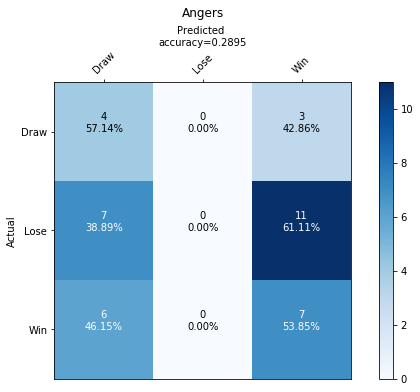

LogisticRegression: Angers test accuracy are: 21.052631578947366


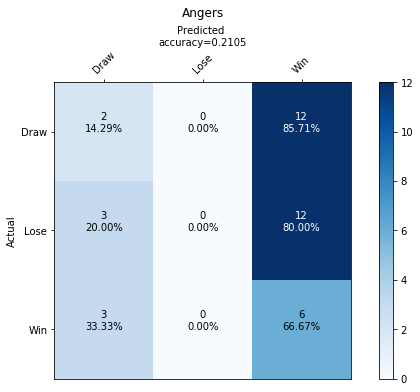

skip Bastia
LogisticRegression: Bordeaux validation accuracy are: 44.73684210526316


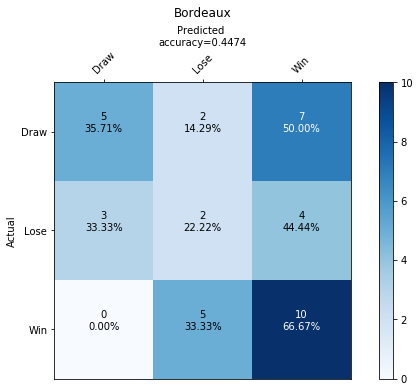

LogisticRegression: Bordeaux test accuracy are: 34.21052631578947


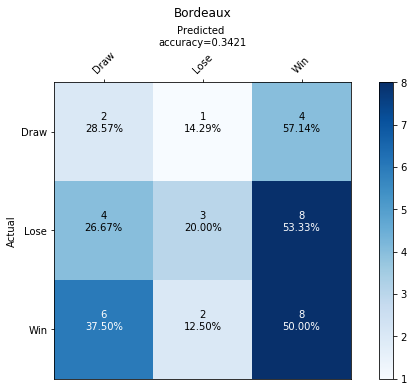

LogisticRegression: Caen validation accuracy are: 47.368421052631575


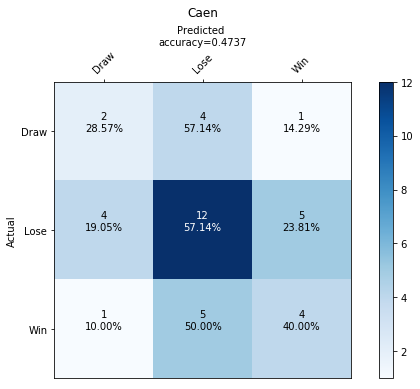

LogisticRegression: Caen test accuracy are: 55.26315789473685


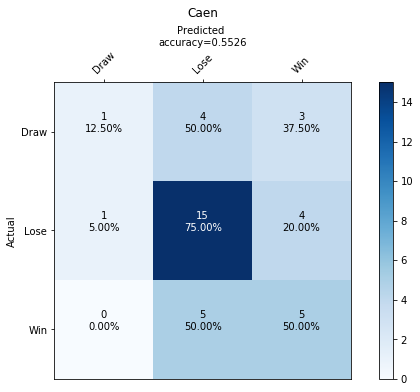

LogisticRegression: Dijon validation accuracy are: 57.89473684210527


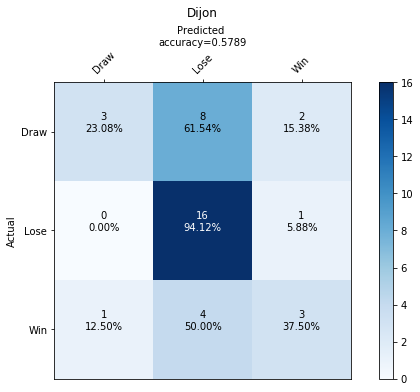

LogisticRegression: Dijon test accuracy are: 50.0


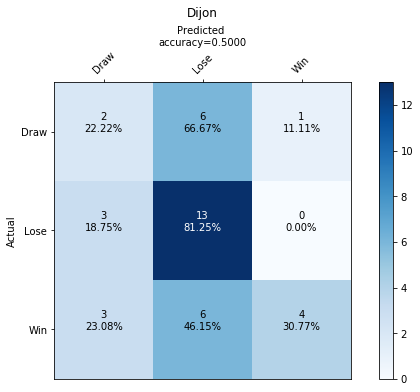

LogisticRegression: Guingamp validation accuracy are: 39.473684210526315


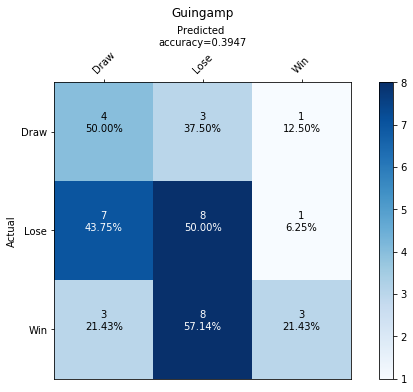

LogisticRegression: Guingamp test accuracy are: 52.63157894736842


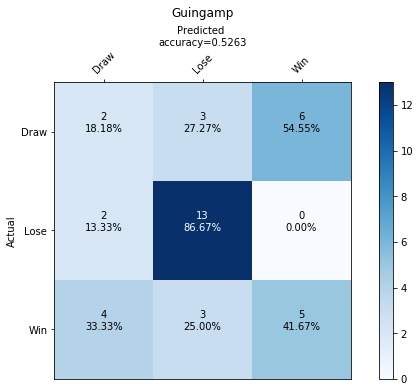

LogisticRegression: Lille validation accuracy are: 39.473684210526315


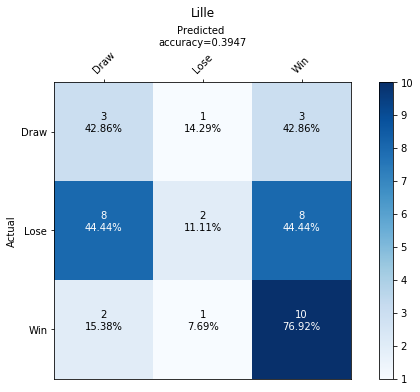

LogisticRegression: Lille test accuracy are: 39.473684210526315


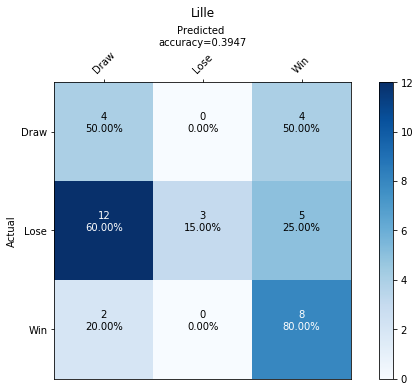

skip Lorient
LogisticRegression: Lyon validation accuracy are: 50.0


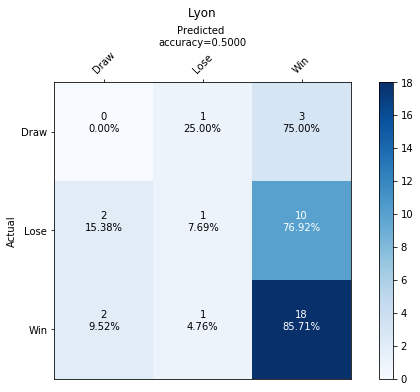

LogisticRegression: Lyon test accuracy are: 50.0


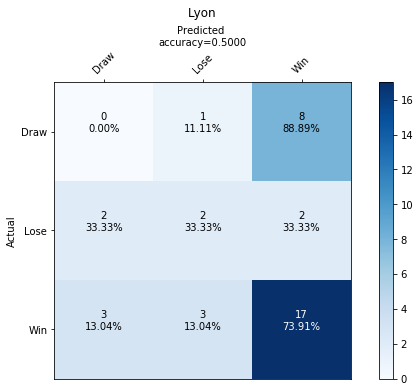

LogisticRegression: Marseille validation accuracy are: 57.89473684210527


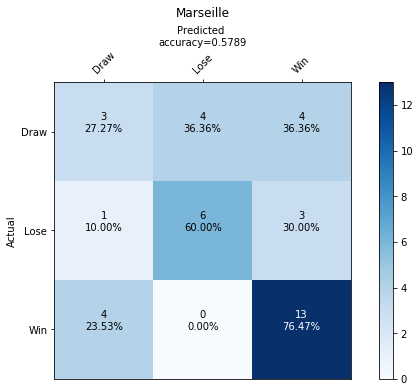

LogisticRegression: Marseille test accuracy are: 60.526315789473685


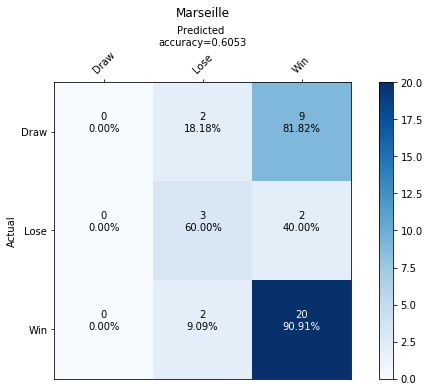

LogisticRegression: Metz validation accuracy are: 42.10526315789473


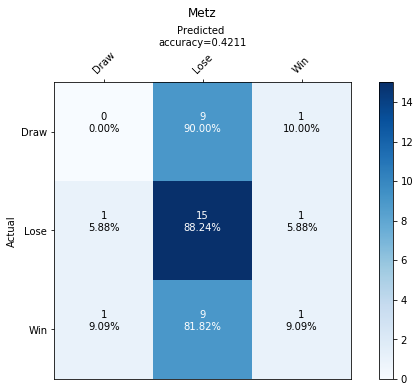

LogisticRegression: Metz test accuracy are: 52.63157894736842


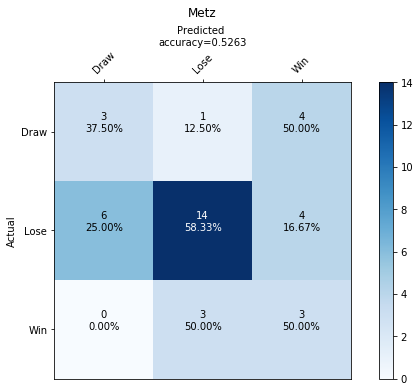

LogisticRegression: Monaco validation accuracy are: 63.1578947368421


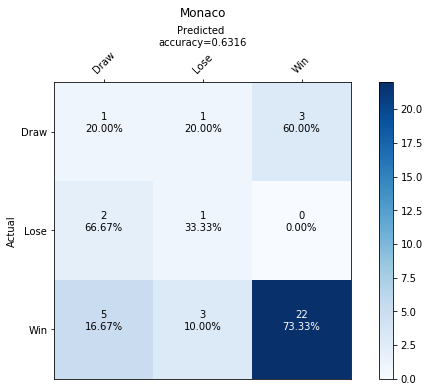

LogisticRegression: Monaco test accuracy are: 63.1578947368421


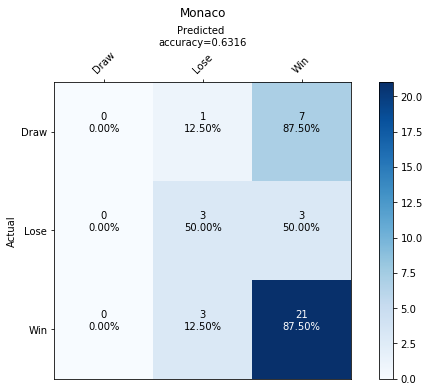

LogisticRegression: Montpellier validation accuracy are: 50.0


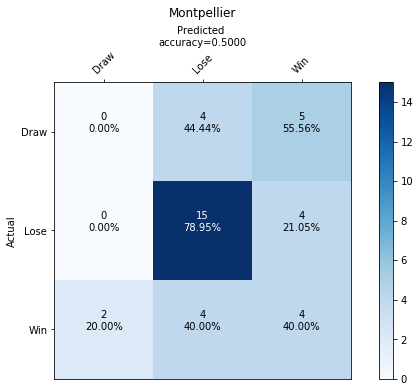

LogisticRegression: Montpellier test accuracy are: 23.684210526315788


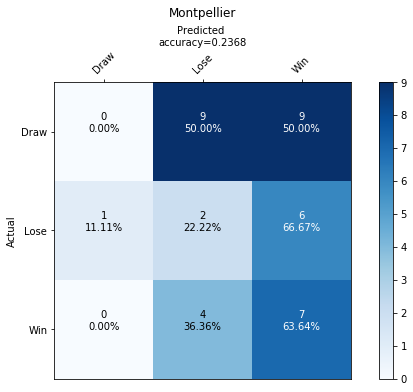

skip Nancy
LogisticRegression: Nantes validation accuracy are: 44.73684210526316


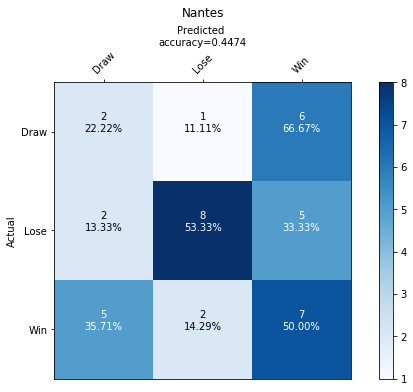

LogisticRegression: Nantes test accuracy are: 39.473684210526315


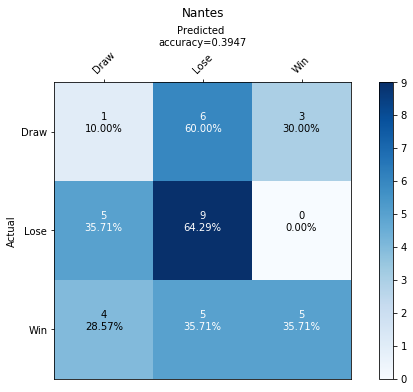

LogisticRegression: Nice validation accuracy are: 34.21052631578947


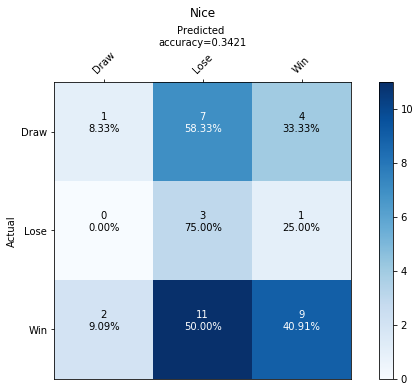

LogisticRegression: Nice test accuracy are: 47.368421052631575


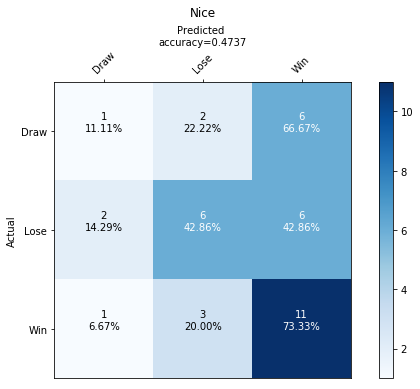

LogisticRegression: Paris SG validation accuracy are: 68.42105263157895


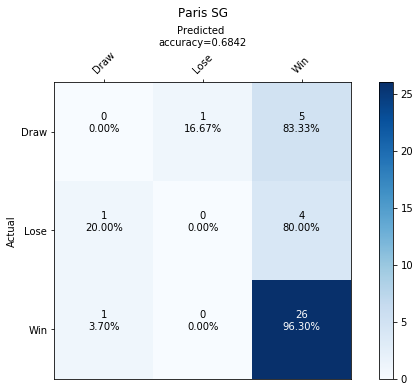

LogisticRegression: Paris SG test accuracy are: 73.68421052631578


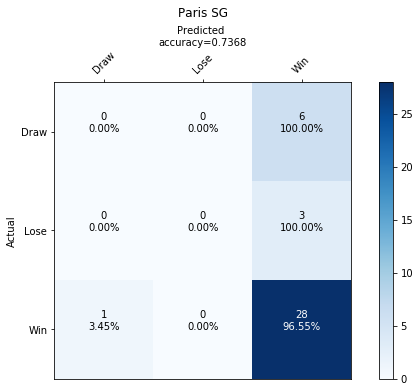

LogisticRegression: Rennes validation accuracy are: 36.84210526315789


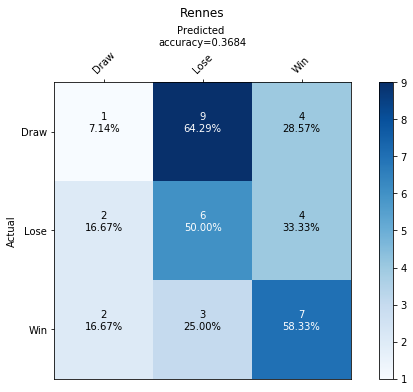

LogisticRegression: Rennes test accuracy are: 34.21052631578947


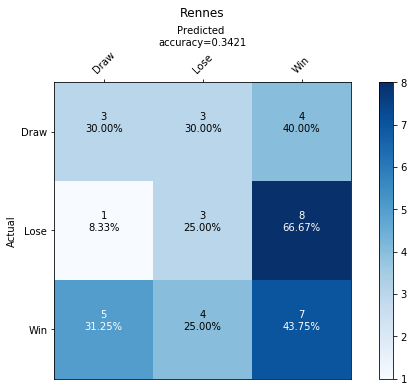

LogisticRegression: St Etienne validation accuracy are: 42.10526315789473


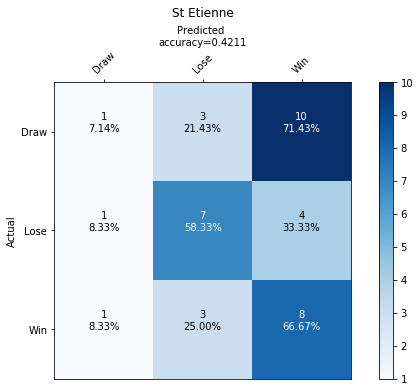

LogisticRegression: St Etienne test accuracy are: 47.368421052631575


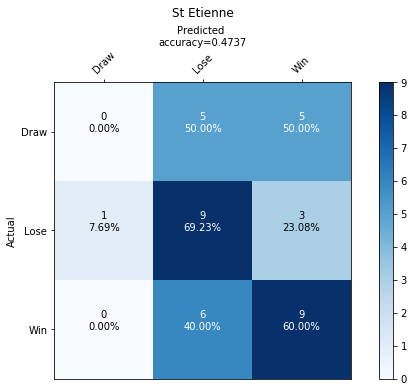

skip Strasbourg
LogisticRegression: Toulouse validation accuracy are: 47.368421052631575


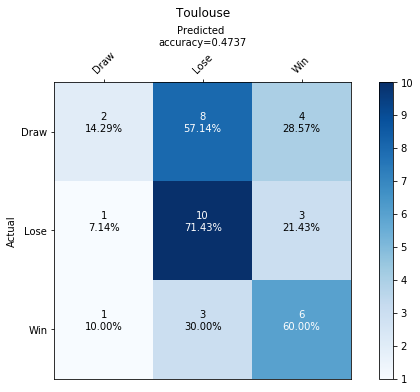

LogisticRegression: Toulouse test accuracy are: 57.89473684210527


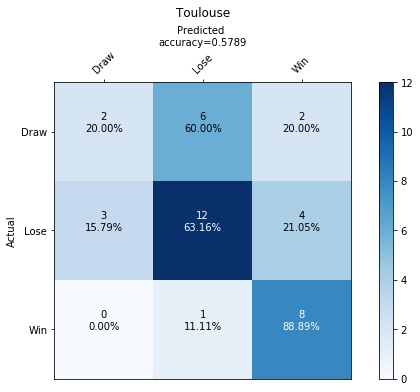

skip Troyes


In [7]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0]
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train['Result'])
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    d = pd.DataFrame(
        data={
            'pred': y_test_pred,
            'actual': y_test['Result'].values
        },
        index=pd.MultiIndex.from_tuples(
            list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
            names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
        cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
        metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
        cm = confusion_matrix(y_test, y_test_pred, labels=classes)
        metrics.plot_confusion_matrix(cm, classes, title=team)
    


In [8]:
for key, groupByPredictor in total.groupby('predictor'):
    print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)

LogisticRegression overall accuracy is  47.21362229102167
